<center><h1>Making Merger Tree from m3p output</h1></center>

In [1]:
import numpy as np
import m3p_merger
import matplotlib.pyplot as plt
import importlib
importlib.reload(m3p_merger)

<module 'm3p_merger' from '/home/uni08/ellis/jupyterhub-gwdg/PeakPatch/m3p_merger/m3p_merger.py'>

In [2]:
# Peak patch data
pathPrefix = "/usr/users/ellis/PeakPatch/m3p/axOut/"

# Unevolved Density fields
DensPath = "/usr/users/ellis/bin/InputFiles/512"
DensSuffix = ['/L6N3_07/axion.m.00115_L6N3_07','/L6N3_06/axion.m.00115_L6N3_06','/L6N3_01/axion.m.00115_L6N3_01']

In [3]:
ppFile = pathPrefix + "../inputs/inputs.ax_manyz"
densFile = DensPath+DensSuffix[0]

peak_list, boxsize = m3p_merger.MakePeakList(ppFile)

<h2><center>Find which trees are interesting</center></h2>

In [4]:
# for i in range(452):
#     out = m3p_merger.BuildMergerTree(peak_list, ppFile, i)
#     if out[10].size>0:
#         print(i, len(out[4]))

<h2><center>Calculate Merger Tree</center></h2>

In [38]:
importlib.reload(m3p_merger)
indicies = np.arange(1000)
out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = indicies)

<h2><center>Plot all peaks on each other</center></h2>

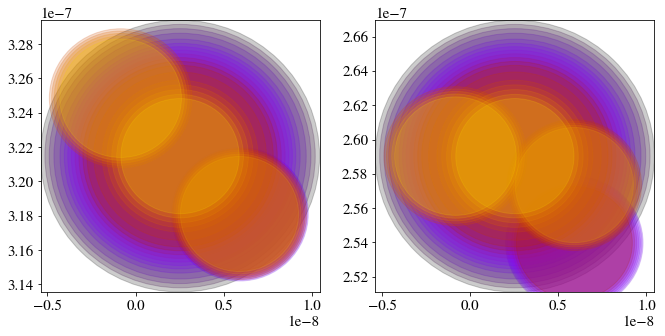

In [39]:
m3p_merger.plotMergerPatches(out[49], ppFile)

<h2><center>Plot merger tree</center></h2>

Collapse redshift: 3088.0


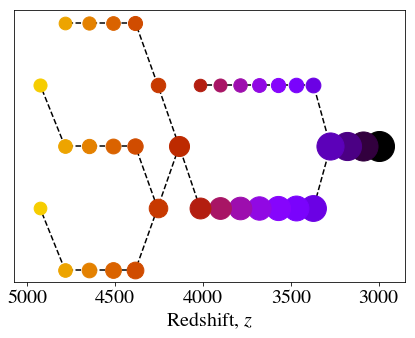

In [71]:
importlib.reload(m3p_merger)
m3p_merger.plotMergerTree(out[49], ppFile, font_size = 20)
print("Collapse redshift: {}".format(m3p_merger.FindCollapseRedshift(out[0], 0.1, ppFile)));

<h2><center>Calculate all collapse redshifts</center></h2>

In [67]:
import time
importlib.reload(m3p_merger)
tic = time.time()
out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 'all')
collapse_redshifts = np.zeros(len(out))
print("Found merger trees in {:.3} seconds".format(time.time()-tic))

tic = time.clock()
for i in range(len(out)):
    collapse_redshifts[i] = m3p_merger.FindCollapseRedshift(out[i], 0.1, ppFile)
print("Found collapse redshifts in {:.3} seconds".format(time.time()-tic))  

Found merger trees in 5.81e+02 seconds
Found collapse redshifts in 1.58e+09 seconds


In [ ]:
masses = np.zeros(len(out))
for i in range(len(out)):
    masses[i] = out[, 4]

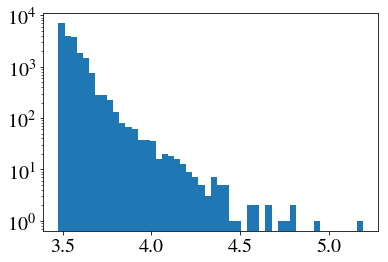

In [70]:
plt.hist(np.log10(collapse_redshifts), log=True, bins = 50);